In [1]:
!
!pip install pandas
!pip install pandas-ta
!pip install plotly
!pip install mplfinance
!pip install matplotlib
!pip install seaborn
!pip install plotly.io
!pip install -U kaleido


[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: Could not find a version that satisfies the requirement plotly.io (from versions: none)
ERROR: No matching distribution found for plotly.io

[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# Importing main libraries

In [2]:
from datetime import datetime
import os
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pandas_ta as ta
import mplfinance as mpf
import yfinance as yf
import plotly.io as pio
from kaleido import *

# Importing datasets
Parsed data from Moscow Exchange
Stock market shares of Yandex and Sovcomflot

In [3]:
def get_data():
    
    assert 'YNDX.csv' and 'FLOT.csv' in os.listdir(), "You need to get the datasets first"
    
    yndxdf = pd.read_csv('YNDX.csv', sep=';')
    flotdf = pd.read_csv('FLOT.csv', sep=';')
    
    yndxdf['name'], flotdf['name'] = 'Yandex', 'Sovcomflot'
    
    return yndxdf, flotdf

# Data preprocessing
changing date format, setting index

In [4]:
def preprocess(df: pd.DataFrame) -> pd.DataFrame:

    """
    Preprocessing the dataframe
    :param df: dataframe, *index must be datetime
    :return: dataframe with datetime index
    """
    
    df['tradedate'] = pd.to_datetime(df['tradedate'], yearfirst=True, format='%Y-%m-%d')
    df.set_index('tradedate', inplace=True)
    
    return df

# Initialising the data
making quick formula

In [5]:
def init():
    yndxdf, flotdf = get_data()
    yndxdf = preprocess(yndxdf)
    flotdf = preprocess(flotdf)
    return yndxdf, flotdf

In [6]:
def title(self):
    return self['name'].iloc[1]

In [7]:
yndxdf, flotdf = init()

# Yahoo Finance API (optional)

If you want to change the stock market share, after my ones you can use this API, 
just call the func below and leave it as it is or change it in following way:

`yndxdf, flotdf = init_yahoo('yahoo_finance_index_1', 'yahoo_finance_index_2')`

if you have no idea, I prepared some examples for you:

`yndxdf, flotdf = init_yahoo('AAPL', 'GOOG')`

`yndxdf, flotdf = init_yahoo('AMZN', 'TSLA')`

The only problem is that **Yahoo Finance API** doesn't work with Russian stock market shares and
all the titles of graphs will not be changed to yours, so you'll see the titles of the previous stock market shares.

*there's no need to use this, if you don't want to explore something by your own interest.*

The project was made using **Moscow Exchange API** which is so terrible, 
I used it to parse the data about exactly Yandex and Sovcomflot.

fun fact: **Yahoo API** work much properly and looks more accurate, than **Moscow Exchange API**.

Nevertheless, if I'd started this project from the beginning, I'd use Yahoo, 
even if I had to change the stock market share.

The only thing you need to do is to change the stock market share in the dictionary below.


In [38]:
def init_yahoo(index1:str='', index2:str='', name1:str='', name2:str=''):
    
    stock = {True: index1, False: index2}
    
    yndx = yf.Ticker(stock[True])
    yndxdf = yndx.history(period='max', interval='1d')
    flot = yf.Ticker(stock[False])
    flotdf = flot.history(period='max', interval='1d')
    
    yndxdf.columns = map(str.lower, yndxdf.columns)
    flotdf.columns = map(str.lower, flotdf.columns)
    
    yndxdf['name'], flotdf['name'] = name1, name2
        
    yndxdf.rename_axis('tradedate', inplace=True)
    flotdf.rename_axis('tradedate', inplace=True)
    
    return yndxdf, flotdf

# Defining functions for calculating technical indicators

* Relative Strength Index (RSI)
    $$
\begin{align*}
RSI = 100 - \frac{100}{1 + RS}
\end{align*}



\begin{align*}
RS & = \frac{\text{AG}}{\text{AL}} \\
\end{align*}


\begin{align*}
\text{AG (Average Gain)} & = \frac{\text{Sum of gains over } n \text{ periods}}{n} \\
\text{AL (Average Loss)} & = \frac{\text{Sum of losses over } n \text{ periods}}{n}
\end{align*}
* Moving Average Convergence Divergence (MACD)
* Simple Moving Average (SMA)

In [9]:
def add_rsi(df_origin: pd.DataFrame, periods: list = []) -> pd.DataFrame:
    
    """
    Calculating RSI (Relative Strength Ratio) indicator
    and adding it to the dataframe
    """
    
    df = df_origin.copy()
    
    for period in periods:
        assert period > 0, "Period must be greater than 0"
        assert period < len(df), "Period must be less than the length of dataframe"
        
        # rsi computed by myself
        delta = df['close'].diff()
        up = delta.copy()
        down = delta.copy()
        up[up < 0] = 0
        down[down > 0] = 0
        roll_up = up.rolling(period).mean()
        roll_down = down.abs().rolling(period).mean()
        my_rsi = 100 - 100 / (1 + roll_up / roll_down)
    
        # the perfect rsi
        accurate_rsi = ta.rsi(df['close'], length=period)
        
        result_df = df.copy()
        result_df[f'my_rsi_{period}'] = my_rsi
        result_df[f'ta_rsi_{period}'] = accurate_rsi
        
        df = result_df
        
    return result_df

    
def add_macd(df, fast=12, slow=26, signal=9):
    
    """
    Calculating MACD indicator
    """
    
    assert fast < slow, f"The slow:{slow} period must be greater than the fast{fast} period"
    assert signal < slow, f"The slow{slow} period must be greater than the signal:{signal} period"
    
    
    macd = ta.macd(df['close'], fast=fast, slow=slow, signal=signal)
    
    return macd


def show_macd(ax, name: str, levels: bool = True, color: str ='blue'):

    """
    Plotting MACD indicator
    """
    
    
    plot = ax.plot(xlabel=f'{name}', title=f'{ax.name}', color=color)
    if levels:
        plot.axhline(0, color='g')
        plot.legend([name, 'MACD'])
    return plot


def add_sma(df, period=30):
    
    """
    Calculating SMA(Simple Moving Average) indicator
    """
    
    sma = ta.sma(df['close'], length=period)
    
    return sma


def add_corr(df_origin: pd.DataFrame, 
             periods: list = [], 
             memories: dict = {},
             cut: dict = {},
             mine: bool = False) -> pd.DataFrame:


    """
    Calculating correlation between two columns and append to a new one
    :param df_origin: dataframe, *index must be datetime
    :param periods: list of all periods of RSI that are in the dataframe
    :param memories: dictionary of all periods of RSI and their memory
    :param cut: dictionary of config of cutting the correlation
    :return: dataframe with correlation columns
    """

    
    assert len(periods) > 0 and len(periods) <= 5, "You need to choose at least 1 period, at most 5 periods"
    assert all([period in memories.keys() for period in periods]), "You need to choose periods for each period"
    assert all([f'ta_rsi_{period}' in df_origin.columns for period in periods]), "You need to calculate RSI first"
    assert all([f'my_rsi_{period}' in df_origin.columns for period in periods]), "You need to calculate RSI first"
    
    
    go = {0: 'ta', 1: 'my'}
    
    df = df_origin.copy()
    
    for period in periods:
        
        memory = memories[period]
        
        for i in range(2):
            if not mine:
                if i == 1:
                    break
            
            result_df, corr = df.copy(), dict()
            result_corr, timesteps = [], [i for i in df.index]
            
            col_1, col_2 = f'close', f'{go[i]}_rsi_{period}'
            new_col, beta = f'corr_{go[i]}_rsi_{period}', 0 
            
            for k in range(len(timesteps)):
                
                tempdf = df.loc[timesteps[max(0,k - memory)]:timesteps[k]].copy()
                result_corr.append(tempdf[col_1].corr(tempdf[col_2]))
        
            
            if len(timesteps) != len(result_corr):
                raise ValueError("num of rows of df and calculated correlation must be equal")
            else:
                
                corr = {x: i for i, x in zip(result_corr, timesteps)}

                if cut and (go[i] in cut['who']) and (cut['how'] == 'front' or cut['how'] == 'all'):
                    for x in corr:
                        if beta < cut['amount']:
                            corr[x] = np.NaN
                        beta += 1
                if cut and (go[i] in cut['who']) and (cut['how'] == 'back' or cut['how'] == 'all'):
                    for x in corr:
                        if beta > len(corr) - cut['amount']:
                            corr[x] = np.NaN
                        beta += 1
                    
                result_df[new_col] = corr
            
            df = result_df
            
    return result_df



# Data visualisation functions
plotting w/ plotly, matplotlib, matplotlibfinance, seaborn

In [10]:
def ly_candlechart(df: pd.DataFrame):

    """
    Plotting candlestick chart with volume bars using plotly library
    """
    
    fig = go.Figure(
        data=[go.Candlestick(
        x=df.index,
        open=df['open'],
        high=df['high'],
        low=df['low'],
        close=df['close']
        )]
    )
    
    fig.update_layout(
        title=f'{title(df)}',
        width=750,
        height=650,
    )
    
    fig.add_trace(
        go.Bar(
        x=df.index,
        y=df['volume'],
        name='Volume',
        marker=dict(color='rgba(255, 255, 255, 0.4)'),
        yaxis='y2'
        )
    )
    
    fig.layout.yaxis2 = dict(domain=[0, 0.3], anchor='x', title='Volume')
    fig.layout.yaxis = dict(domain=[0.3, 1], anchor='x', title='Price')
    
    
    return fig


def ly_linegraph(df: pd.DataFrame, title: str = 'stock market'):
    
    """
    Plotting line chart using plotly library
    """
    
    fig = go.Figure(
        data=[go.Scatter(
        x=df.index,
        y=df['close'],
        )],
    )
    
    fig.update_layout(
        title=f'{title}',
        width=700,
        height=700,
    )
    
    fig.show()


def mpl_candlechart(df):
    
    """
    Plotting candlestick chart with volume bars using mplfinance library
    """
    
    mpf.plot(
            df, 
            title=f'{title(df)}', 
            type='candle', 
            mav=(3, 7), 
            volume=True, 
            show_nontrading=True, 
            style='yahoo', 
            figsize=(10, 6)
    )
    mpf.show()


def sns_linegraph(df):
    
    """
    Plotting line chart using seaborn library
    """
    
    sns.set(style="darkgrid")
    sns.lineplot(x="tradedate", y="close", data=df)
    plt.show()


def fig_rsi(df: pd.DataFrame,
            periods: list = [14],
            graph: bool = False,
            mpl: bool = False, 
            sns: bool = False,
            ly: bool = False,
            mine: bool = True,
            levels: bool = True) -> go.Figure:
    
    """
    Plotting RSI indicator by itself or creates matplotlib subplot
    :param df: dataframe, *index must be datetime
    :param periods: list of all periods of RSI that are in the dataframe
    :param graph: is the graph with candlestick chart and correlation needed
    :param levels: is the standart (30,70) levels of RSI needed 
    :param mpl: use matplotlib library
    :param sns: use seaborn library
    :param ly: use plotly library
    :return: 
    """
    
    
    
    if mine:
        assert all([f'my_rsi_{period}' in df.columns for period in periods]), "You need to calculate RSI first"
    assert all([f'ta_rsi_{period}' in df.columns for period in periods]), "You need to calculate RSI first"
    assert mpl + sns + ly <= 1, "You can choose only one library to plot"
    assert len(periods) > 0, "You need to choose at least one period"
    assert len(periods) <= 5, "You can't plot more than 5 graphs"
    
    if graph:
        assert all([f'corr_ta_rsi_{period}' in df.columns for period in periods]), "You need to calculate correlation first to plot graph"
        if mine:
            assert all([f'corr_my_rsi_{period}' in df.columns for period in periods]), "You need to calculate correlation first to plot graph"
    
    if ly:
        
        if levels:
            
            level1 = go.Scatter(
                x=df.index,
                y=[30 for i in range(len(df.index))],
                name = 'oversold',
                opacity=0.5,
                fillcolor='green'
                )
                
            level2 = go.Scatter(
                x=df.index,
                y=[70 for i in range(len(df.index))],
                name = 'overbought',
                opacity=0.5,
                fillcolor='red'
                )
        
        iterate, alp = len(periods), 0
        
        if len(periods) > 1:
            
            if not graph:
                
                fig = make_subplots(rows=1, cols=iterate, shared_xaxes=True, shared_yaxes=True,horizontal_spacing=0.05, vertical_spacing=0.01)
                fig.update_layout(width=1100, height=500, barmode='overlay', title=f'{title(df)} RSI{periods} {str(df.index[0]).split()[0]} - {str(df.index[-1]).split()[0]}')
                
                for i in range(iterate):
                    
                    if alp >= len(periods):
                        break
                    
                    taplot = go.Scatter(
                    x=df.index,
                    y=df[f'ta_rsi_{periods[alp]}'],
                    name = f'ta RSI{periods[alp]}'
                    )
                    
                    fig.add_trace(taplot, row=1, col=i + 1)
                    
                    if mine:
                        myplot = go.Scatter(
                        x=df.index,
                        y=df[f'my_rsi_{periods[alp]}'],
                        name = f'my RSI{periods[alp]}'
                        )
                        
                        fig.add_trace(myplot, row=1, col=i + 1)
                        
                    if levels:
                        fig.add_trace(level1, col=i + 1, row=1)
                        fig.add_trace(level2, col=i + 1, row=1)
                        
                    alp += 1
                    
            else:
                
                fig = make_subplots(rows=3, cols=iterate, shared_xaxes=True, shared_yaxes=True, horizontal_spacing=0.05, vertical_spacing=0.01)
                fig.update_layout(width=1300, height=900, barmode='overlay', title=f'{title(df)} RSI{periods} {str(df.index[0]).split()[0]} - {str(df.index[-1]).split()[0]}')
                
                for i in range(iterate):
                    
                    if alp >= len(periods):
                        break
                    
                    fig.add_trace(ly_candlechart(df).data[0], row=3, col=i + 1)

                    taplot = go.Scatter(
                    x=df.index,
                    y=df[f'ta_rsi_{periods[alp]}'],
                    name = f'ta RSI{periods[alp]}'
                    )
                    
                    fig.add_trace(taplot, row=1, col=i + 1)
                    
                    if mine:
    
                        myplot = go.Scatter(
                        x=df.index,
                        y=df[f'my_rsi_{periods[alp]}'],
                        name = f'my RSI{periods[alp]}'
                        )
                        
                        fig.add_trace(myplot, row=1, col=i + 1)
                    
                    tacorrplot = go.Scatter(
                    x=df.index,
                    y=df[f'corr_ta_rsi_{periods[alp]}'],
                    name = f'corr ta RSI{periods[alp]}'
                    )
                    
                    fig.add_trace(tacorrplot, row=2, col=i + 1)
                    
                    if mine:
                        mycorrplot = go.Scatter(
                        x=df.index,
                        y=df[f'corr_my_rsi_{periods[alp]}'],
                        name = f'corr my RSI{periods[alp]}'
                        )
                        
                        fig.add_trace(mycorrplot, row=2, col=i + 1)
                        
                    if levels:
                        fig.add_trace(level1, col=i + 1, row=1)
                        fig.add_trace(level2, col=i + 1, row=1)
                    
                    alp += 1
        
        else:

            if not graph:
                
                fig = make_subplots(rows=1, cols=1, shared_xaxes=True, shared_yaxes=True, horizontal_spacing=0.05, vertical_spacing=0.01)
                fig.update_layout(width=1200, height=700, barmode='overlay', title=f'{title(df)} RSI{periods} {str(df.index[0]).split()[0]} - {str(df.index[-1]).split()[0]}')
                
                taplot = go.Scatter(
                x=df.index,
                y=df[f'ta_rsi_{periods[0]}'],
                name = f'ta RSI{periods[0]}'
                )
                        
                fig.add_trace(taplot, row=1, col=1)
                
                if mine:
                    
                    myplot = go.Scatter(
                    x=df.index,
                    y=df[f'my_rsi_{periods[0]}'],
                    name = f'my RSI{periods[0]}'
                    )
                
                    fig.add_trace(myplot, row=1, col=1)
                
                if levels:
                    fig.add_trace(level1, col=1, row=1)
                    fig.add_trace(level2, col=1, row=1)
                    
            else:
                
                
                
                fig = make_subplots(rows=3, cols=1, shared_xaxes=True, shared_yaxes=False, horizontal_spacing=0.05, vertical_spacing=0.01)
                fig.update_layout(width=700, height=1200, barmode='overlay', title=f'{title(df)} RSI{periods} {str(df.index[0]).split()[0]} - {str(df.index[-1]).split()[0]}')
                
                fig.add_trace(ly_candlechart(df).data[0], row=3, col=1)

                taplot = go.Scatter(
                x=df.index,
                y=df[f'ta_rsi_{periods[0]}'],
                name = f'ta RSI{periods[0]}'
                )
                    
                fig.add_trace(taplot, row=1, col=1)
                
                if mine:
                        
                    myplot = go.Scatter(
                    x=df.index,
                    y=df[f'my_rsi_{periods[0]}'],
                    name = f'my RSI{periods[0]}'
                    )
                
                    fig.add_trace(myplot, row=1, col=1)
                
                tacorrplot = go.Scatter(
                x=df.index,
                y=df[f'corr_ta_rsi_{periods[alp]}'],
                name = f'corr ta RSI{periods[alp]}'
                )
                
                fig.add_trace(tacorrplot, row=2, col=1)
                
                if mine:
                    
                    mycorrplot = go.Scatter(
                    x=df.index,
                    y=df[f'corr_my_rsi_{periods[alp]}'],
                    name = f'corr my RSI{periods[alp]}'
                    )
                    
                    fig.add_trace(mycorrplot, row=2, col=1)
                    
                if levels:
                    fig.add_trace(level1, col=1, row=1)
                    fig.add_trace(level2, col=1, row=1)
            
        return fig
        
    elif mpl:
        plt.plot(df['my_rsi'])
        plt.plot(df['ta_rsi'])
        return plt
    
    elif sns:
        sns.lineplot(x="tradedate", y="my_rsi", data=df)
        sns.lineplot(x="tradedate", y="ta_rsi", data=df)


def fig_macd(df: pd.DataFrame,
             periods: list = [12, 26, 9],
             graph: bool = False,
             mpl: bool = False, 
             sns: bool = False,
             ly: bool = False):
    
    """
    Plotting MACD indicator by itself or creates matplotlib subplot
    :param df: dataframe, *index must be datetime
    :param periods: list of all periods of MACD that are in the dataframe
    :param only_macd: parameter if to plot only MACD indicator, without candlestick chart
    :param mpl: use matplotlib library
    :param sns: use seaborn library
    :param ly: use plotly library
    :return: 
    """
    
    assert mpl + sns + ly <= 1, "You can choose only one library to plot"
    assert len(periods) > 0, "You need to choose at least one period"
    assert all([f'macd_{period}' in df.columns for period in periods]), "You need to calculate MACD first"
    
    

# Adding functions for changing candle's periods

In [11]:
def weekly_candles(df):
    
    """
    Changing candle's period to week
    """
    
    # Ensure the index is a datetime index
    df.index = pd.to_datetime(df.index)

    weekly_df = df.resample('W').agg(
        {
        'open': 'first', 
        'high': 'max', 
        'low': 'min', 
        'close': 'last', 
        'volume': 'sum',
        'name': 'first'
        }
    )

    return weekly_df


def monthly_candles(df):
    
    """
    Changing candle's period to month
    """
    
    # Ensure the index is a datetime index
    df.index = pd.to_datetime(df.index)

    monthly_df = df.resample('M').agg(
        {
        'open': 'first', 
        'high': 'max', 
        'low': 'min', 
        'close': 'last', 
        'volume': 'sum',
        'name': 'first'
        }
    )

    return monthly_df



**call this function if you want to use yahoo finance**

# Visualising the data using functions above

**Plotting each graph as a test, 2022 January - 2023 January**

In [12]:
flotdf = flotdf['2021-08-01':'2022-06-10']
yndxdf = yndxdf['2021-08-01':'2022-06-10']

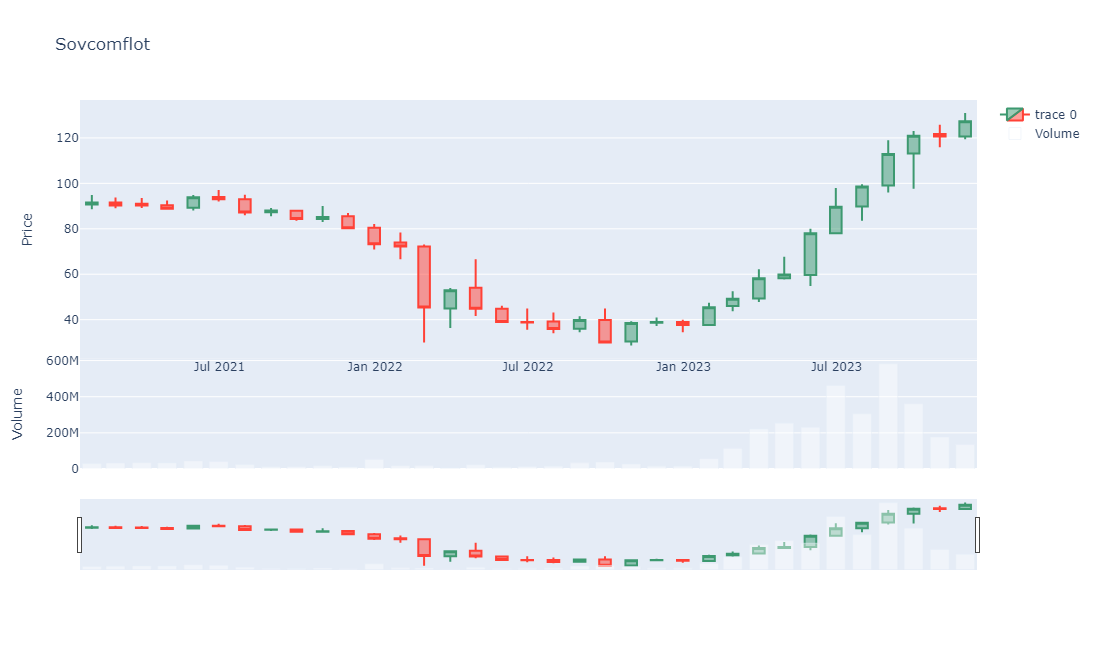

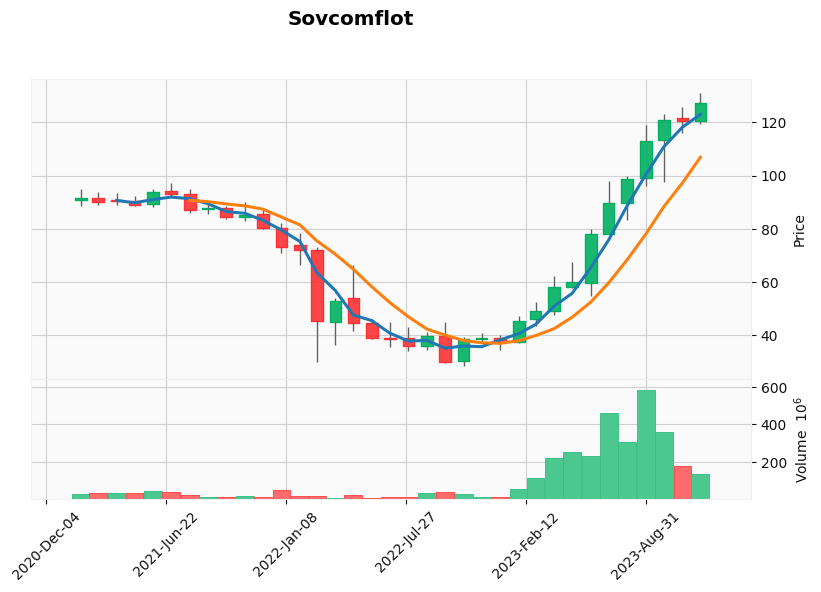

AttributeError: 'NoneType' object has no attribute 'savefig'

In [43]:
ly_candlechart(monthly_candles(flotdf)).show()
mpl_candlechart(monthly_candles(flotdf))

In [ ]:
ly_candlechart(monthly_candles(yndxdf)).show()
mpl_candlechart(monthly_candles(yndxdf))

Let's test the RSI indicator

# RSI indicator function testing
We're about to compare my RSI indicator with the perfect one to check anomalies

* **ta** - perfect RSI indicator
* **my** - my RSI indicator
* **corr** - correlation between **ta** or **my** RSI and the price

Lets look at them closely and then look what happens if we has COVID pandemic


In [48]:
yndxdf, flotdf = init()

flotdf = flotdf['2021-01-01':'2022-01-10']
yndxdf = yndxdf['2021-01-01':'2022-01-10']

yndxdf = add_rsi(yndxdf, periods=[7, 14])
flotdf = add_rsi(flotdf, periods=[7, 14])
with np.errstate(all='ignore'):
    yndxdf = add_corr(yndxdf, periods=[7, 14], memories={7: 60, 14: 120}, cut={"who": ["my"], "how": "front", "amount": 20}, mine=True)
with np.errstate(all='ignore'):
    flotdf = add_corr(flotdf, periods=[7, 14], memories={7: 60, 14: 120}, cut={"who": ["my"], "how": "front", "amount": 20}, mine=True)
fig1 = fig_rsi(yndxdf, periods=[7, 14], ly=True, graph=True, mine=True, levels=True)
fig2 = fig_rsi(flotdf, periods=[7, 14], ly=True, graph=True, mine=True, levels=True)
pio.write_image(fig1, "figure1.png", format="png")
pio.write_image(fig2, "figure2.png", format="png")

C:\Users\Zheny\Desktop\deploy\venv\Lib\site-packages\numpy\lib\function_base.py:2889: RuntimeWarning:

Degrees of freedom <= 0 for slice

C:\Users\Zheny\Desktop\deploy\venv\Lib\site-packages\numpy\lib\function_base.py:2889: RuntimeWarning:

Degrees of freedom <= 0 for slice

C:\Users\Zheny\Desktop\deploy\venv\Lib\site-packages\numpy\lib\function_base.py:2889: RuntimeWarning:

Degrees of freedom <= 0 for slice

C:\Users\Zheny\Desktop\deploy\venv\Lib\site-packages\numpy\lib\function_base.py:2889: RuntimeWarning:

Degrees of freedom <= 0 for slice

C:\Users\Zheny\Desktop\deploy\venv\Lib\site-packages\numpy\lib\function_base.py:2889: RuntimeWarning:

Degrees of freedom <= 0 for slice

C:\Users\Zheny\Desktop\deploy\venv\Lib\site-packages\numpy\lib\function_base.py:2889: RuntimeWarning:

Degrees of freedom <= 0 for slice

C:\Users\Zheny\Desktop\deploy\venv\Lib\site-packages\numpy\lib\function_base.py:2889: RuntimeWarning:

Degrees of freedom <= 0 for slice

C:\Users\Zheny\Desktop\deploy\venv

In [50]:
yndxdf, flotdf = init()

flotdf = flotdf['2022-01-01':'2023-01-10']
yndxdf = yndxdf['2022-01-01':'2023-01-10']

yndxdf = add_rsi(yndxdf, periods=[7, 14])
flotdf = add_rsi(flotdf, periods=[7, 14])
with np.errstate(all='ignore'):
    yndxdf = add_corr(yndxdf, periods=[7, 14], memories={7: 30, 14: 45}, cut={"who": ["my"], "how": "front", "amount": 20}, mine=True)
with np.errstate(all='ignore'):
    flotdf = add_corr(flotdf, periods=[7, 14], memories={7: 30, 14: 45}, cut={"who": ["my"], "how": "front", "amount": 20}, mine=True)
fig1 = fig_rsi(yndxdf, periods=[7, 14], ly=True, graph=True, mine=True, levels=True)
fig2 = fig_rsi(flotdf, periods=[7, 14], ly=True, graph=True, mine=True, levels=True)
pio.write_image(fig1, "figure3.png", format="png")
pio.write_image(fig2, "figure4.png", format="png")

C:\Users\Zheny\Desktop\deploy\venv\Lib\site-packages\numpy\lib\function_base.py:2889: RuntimeWarning:

Degrees of freedom <= 0 for slice

C:\Users\Zheny\Desktop\deploy\venv\Lib\site-packages\numpy\lib\function_base.py:2889: RuntimeWarning:

Degrees of freedom <= 0 for slice

C:\Users\Zheny\Desktop\deploy\venv\Lib\site-packages\numpy\lib\function_base.py:2889: RuntimeWarning:

Degrees of freedom <= 0 for slice

C:\Users\Zheny\Desktop\deploy\venv\Lib\site-packages\numpy\lib\function_base.py:2889: RuntimeWarning:

Degrees of freedom <= 0 for slice

C:\Users\Zheny\Desktop\deploy\venv\Lib\site-packages\numpy\lib\function_base.py:2889: RuntimeWarning:

Degrees of freedom <= 0 for slice

C:\Users\Zheny\Desktop\deploy\venv\Lib\site-packages\numpy\lib\function_base.py:2889: RuntimeWarning:

Degrees of freedom <= 0 for slice

C:\Users\Zheny\Desktop\deploy\venv\Lib\site-packages\numpy\lib\function_base.py:2889: RuntimeWarning:

Degrees of freedom <= 0 for slice

C:\Users\Zheny\Desktop\deploy\venv

In [52]:
yndxdf, flotdf = init()

flotdf = flotdf['2021-01-01':'2022-01-10']
yndxdf = yndxdf['2021-01-01':'2022-01-10']

yndxdf = add_rsi(yndxdf, periods=[7, 14])
flotdf = add_rsi(flotdf, periods=[7, 14])
with np.errstate(all='ignore'):
    yndxdf = add_corr(yndxdf, periods=[7, 14], memories={7: 7, 14: 14}, cut={"who": ["my"], "how": "front", "amount": 20}, mine=True)
with np.errstate(all='ignore'):
    flotdf = add_corr(flotdf, periods=[7, 14], memories={7: 7, 14: 14}, cut={"who": ["my"], "how": "front", "amount": 20}, mine=True)
fig1 = fig_rsi(yndxdf, periods=[7, 14], ly=True, graph=True, mine=True, levels=True)
fig2 = fig_rsi(flotdf, periods=[7, 14], ly=True, graph=True, mine=True, levels=True)
pio.write_image(fig1, "figure5.png", format="png")
pio.write_image(fig2, "figure6.png", format="png")                     

C:\Users\Zheny\Desktop\deploy\venv\Lib\site-packages\numpy\lib\function_base.py:2889: RuntimeWarning:

Degrees of freedom <= 0 for slice

C:\Users\Zheny\Desktop\deploy\venv\Lib\site-packages\numpy\lib\function_base.py:2889: RuntimeWarning:

Degrees of freedom <= 0 for slice

C:\Users\Zheny\Desktop\deploy\venv\Lib\site-packages\numpy\lib\function_base.py:2889: RuntimeWarning:

Degrees of freedom <= 0 for slice

C:\Users\Zheny\Desktop\deploy\venv\Lib\site-packages\numpy\lib\function_base.py:2889: RuntimeWarning:

Degrees of freedom <= 0 for slice

C:\Users\Zheny\Desktop\deploy\venv\Lib\site-packages\numpy\lib\function_base.py:2889: RuntimeWarning:

Degrees of freedom <= 0 for slice

C:\Users\Zheny\Desktop\deploy\venv\Lib\site-packages\numpy\lib\function_base.py:2889: RuntimeWarning:

Degrees of freedom <= 0 for slice

C:\Users\Zheny\Desktop\deploy\venv\Lib\site-packages\numpy\lib\function_base.py:2889: RuntimeWarning:

Degrees of freedom <= 0 for slice

C:\Users\Zheny\Desktop\deploy\venv

In [ ]:
fig_rsi(yndxdf, periods=[7, 14], ly=True, graph=True, mine=True, levels=True).show()

In [ ]:
fig_rsi(flotdf, periods=[7, 14], ly=True, graph=True, mine=True, levels=True).show()

In [ ]:
fig_rsi(flotdf, periods=[7, 14], ly=True, graph=True, mine=False, levels=True).show()

**obviously, the correlation of my RSI is not perfect, if we try looking at them closely.**
then lets pick from our data small part

In [56]:
fig1 = fig_rsi(yndxdf['2021-06-01':'2022-01-01'], periods=[7, 14], ly=True, graph=True, mine=False, levels=True)
fig2 = fig_rsi(flotdf['2021-06-01':'2022-01-01'], periods=[7, 14], ly=True, graph=True, mine=False, levels=True)
pio.write_image(fig1, "perfectYNDX.png", format="png")
pio.write_image(fig2, "perfectFLOT.png", format="png")    

In [54]:
flotPerfect

In [55]:
fig_rsi(flotdf, periods=[7], ly=True, graph=True, mine=True, levels=True).show()
fig_rsi(flotdf, periods=[14], ly=True, graph=True, mine=True, levels=True).show()

Since now, lets use only the perfect one, to avoid any mistakes

# Plot each graph during the COVID pandemic, 2021 September - 2023 January 

In [67]:
yndxdf, flotdf = init()


yndxdf = add_rsi(yndxdf, periods=[17, 35])
flotdf = add_rsi(flotdf, periods=[17, 35])
with np.errstate(all='ignore'):
    yndxdf = add_corr(yndxdf, periods=[17, 35], memories={17: 17, 35: 35}, cut={"who": ["my"], "how": "front", "amount": 20}, mine=True)
with np.errstate(all='ignore'):
    flotdf = add_corr(flotdf, periods=[17, 35], memories={17:17, 35:35}, cut={"who": ["my"], "how": "front", "amount": 20}, mine=True)
flotdf = flotdf['2021-09-01':'2022-05-10']
yndxdf = yndxdf['2021-09-01':'2022-05-10']


fig1 = fig_rsi(yndxdf['2021-06-01':'2022-01-01'], periods=[17, 35], ly=True, graph=True, mine=False, levels=True)
fig2 = fig_rsi(flotdf['2021-06-01':'2022-01-01'], periods=[17, 35], ly=True, graph=True, mine=False, levels=True)
pio.write_image(fig1, "YNDXCoviddRSIequal.png", format="png")
pio.write_image(fig2, "FLOTCoviddRSIequal.png", format="png")    

C:\Users\Zheny\Desktop\deploy\venv\Lib\site-packages\numpy\lib\function_base.py:2889: RuntimeWarning:

Degrees of freedom <= 0 for slice

C:\Users\Zheny\Desktop\deploy\venv\Lib\site-packages\numpy\lib\function_base.py:2889: RuntimeWarning:

Degrees of freedom <= 0 for slice

C:\Users\Zheny\Desktop\deploy\venv\Lib\site-packages\numpy\lib\function_base.py:2889: RuntimeWarning:

Degrees of freedom <= 0 for slice

C:\Users\Zheny\Desktop\deploy\venv\Lib\site-packages\numpy\lib\function_base.py:2889: RuntimeWarning:

Degrees of freedom <= 0 for slice

C:\Users\Zheny\Desktop\deploy\venv\Lib\site-packages\numpy\lib\function_base.py:2889: RuntimeWarning:

Degrees of freedom <= 0 for slice

C:\Users\Zheny\Desktop\deploy\venv\Lib\site-packages\numpy\lib\function_base.py:2889: RuntimeWarning:

Degrees of freedom <= 0 for slice

C:\Users\Zheny\Desktop\deploy\venv\Lib\site-packages\numpy\lib\function_base.py:2889: RuntimeWarning:

Degrees of freedom <= 0 for slice

C:\Users\Zheny\Desktop\deploy\venv

In [68]:
yndxdf, flotdf = init()

yndxdf = add_rsi(yndxdf, periods=[17, 35])
flotdf = add_rsi(flotdf, periods=[17, 35])
with np.errstate(all='ignore'):
    yndxdf = add_corr(yndxdf, periods=[17, 35], memories={17: 5, 35: 7}, cut={"who": ["my"], "how": "front", "amount": 20}, mine=True)
with np.errstate(all='ignore'):
    flotdf = add_corr(flotdf, periods=[17, 35], memories={17:5, 35:7}, cut={"who": ["my"], "how": "front", "amount": 20}, mine=True)
flotdf = flotdf['2021-09-01':'2022-05-10']
yndxdf = yndxdf['2021-09-01':'2022-05-10']


fig1 = fig_rsi(yndxdf['2021-06-01':'2022-01-01'], periods=[17, 35], ly=True, graph=True, mine=False, levels=True)
fig2 = fig_rsi(flotdf['2021-06-01':'2022-01-01'], periods=[17, 35], ly=True, graph=True, mine=False, levels=True)
pio.write_image(fig1, "YNDXCoviddRSIsmall.png", format="png")
pio.write_image(fig2, "FLOTCoviddRSIsmall.png", format="png") 

C:\Users\Zheny\Desktop\deploy\venv\Lib\site-packages\numpy\lib\function_base.py:2889: RuntimeWarning:

Degrees of freedom <= 0 for slice

C:\Users\Zheny\Desktop\deploy\venv\Lib\site-packages\numpy\lib\function_base.py:2889: RuntimeWarning:

Degrees of freedom <= 0 for slice

C:\Users\Zheny\Desktop\deploy\venv\Lib\site-packages\numpy\lib\function_base.py:2889: RuntimeWarning:

Degrees of freedom <= 0 for slice

C:\Users\Zheny\Desktop\deploy\venv\Lib\site-packages\numpy\lib\function_base.py:2889: RuntimeWarning:

Degrees of freedom <= 0 for slice

C:\Users\Zheny\Desktop\deploy\venv\Lib\site-packages\numpy\lib\function_base.py:2889: RuntimeWarning:

Degrees of freedom <= 0 for slice

C:\Users\Zheny\Desktop\deploy\venv\Lib\site-packages\numpy\lib\function_base.py:2889: RuntimeWarning:

Degrees of freedom <= 0 for slice

C:\Users\Zheny\Desktop\deploy\venv\Lib\site-packages\numpy\lib\function_base.py:2889: RuntimeWarning:

Degrees of freedom <= 0 for slice

C:\Users\Zheny\Desktop\deploy\venv

In [ ]:
ly_candlechart(weekly_candles(flotdf)).show()
mpl_candlechart(weekly_candles(flotdf))

As you can see, the graphs are almost the same, Moscow Exchange closed ot the begging of 2022 year
In both cases, the price is decreasing, but the price of Sovcomflot is decreasing much faster than the price of Yandex
Price of Yandex fell from 6000 to 2000, while the price of Sovcomflot fell from 90 to 40.


In [ ]:
yndxdf = add_rsi(yndxdf, periods=[7,14])

with np.errstate(all='ignore'):
    yndxdf = add_corr(yndxdf, periods=[7, 14], memories={7: 45, 14: 45}, cut={"who": ["my"], "how": "front", "amount": 20}, mine=True)
    
fig_rsi(yndxdf, periods=[7, 14], ly=True, graph=True, mine=True, levels=True).show()

In [13]:
yndxdf, flotdf = init_yahoo('CL=F', 'GC=F', 'Crude Oil', 'Gold')

yndxdf = add_rsi(yndxdf, periods=[7, 14, 25])
flotdf = add_rsi(flotdf, periods=[7, 14, 25])
with np.errstate(all='ignore'):
    yndxdf = add_corr(yndxdf, periods=[7, 14, 25], memories={7: 15, 14: 25, 25:7}, cut={"who": ["my"], "how": "front", "amount": 20}, mine=False)
with np.errstate(all='ignore'):
    flotdf = add_corr(flotdf, periods=[7, 14, 25], memories={7: 15, 14: 25, 25:7}, cut={"who": ["my"], "how": "front", "amount": 20}, mine=False)
    

yndxdf = yndxdf['2021-06-01':'2022-05-10']
flotdf = flotdf['2021-06-01':'2022-05-10']


fig1 = fig_rsi(yndxdf['2021-06-01':'2022-01-01'], periods=[7, 14, 25], ly=True, graph=True, mine=False, levels=True)
fig2 = fig_rsi(flotdf['2021-06-01':'2022-01-01'], periods=[7, 14, 25], ly=True, graph=True, mine=False, levels=True)
pio.write_image(fig1, "AssumptionCrudeOildRSI.png", format="png")
pio.write_image(fig2, "AssumptionGolddRSI.png", format="png")    

NameError: name 'init_yahoo' is not defined

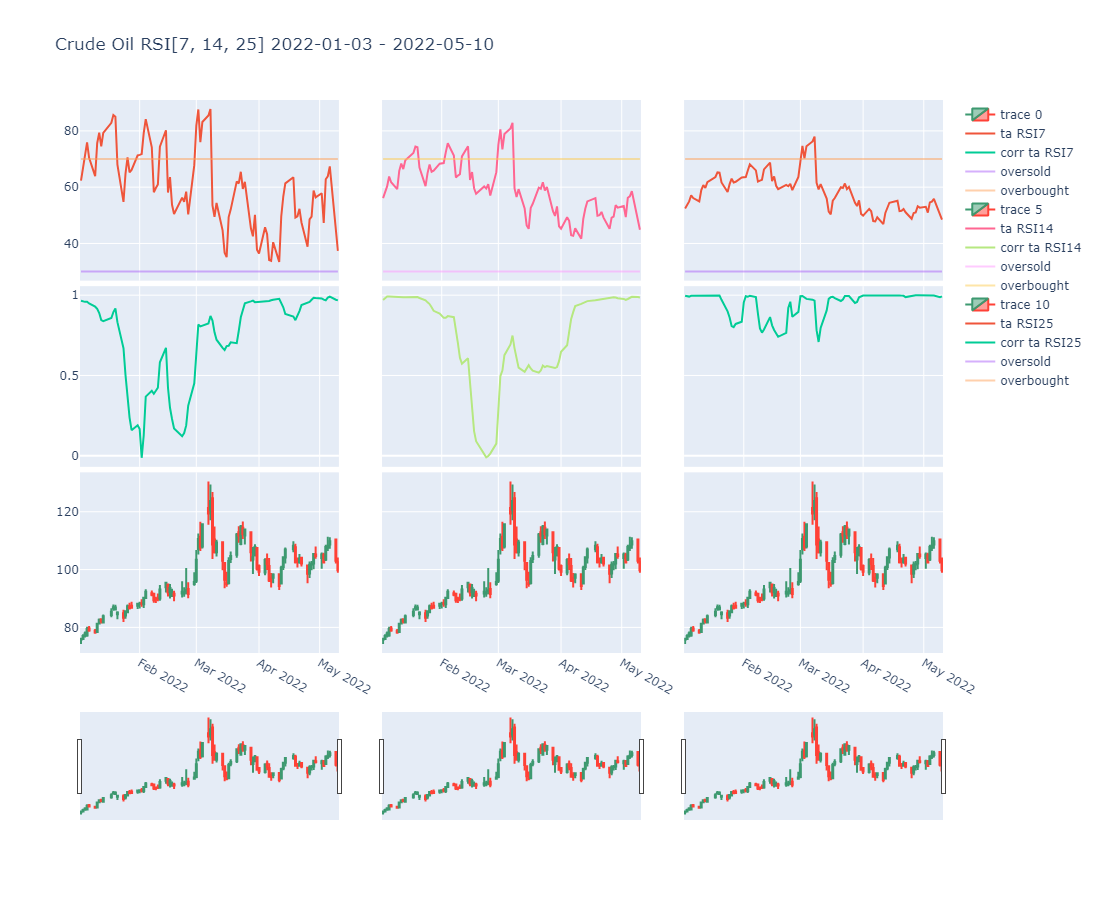

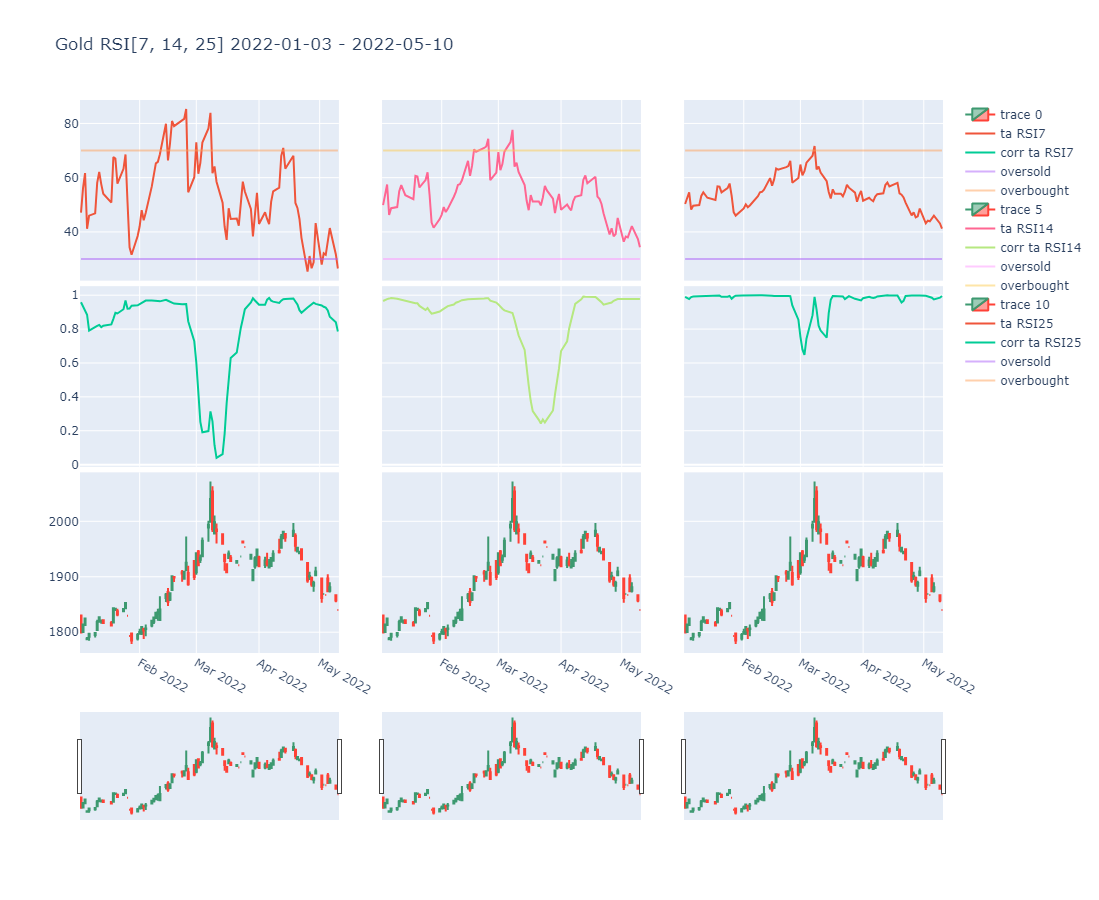

In [66]:
yndxdf = yndxdf['2022-01-01':'2022-09-10']
flotdf = flotdf['2022-01-01':'2022-09-10']

fig_rsi(yndxdf, periods=[7, 14, 25], ly=True, graph=True, mine=False, levels=True).show()
fig_rsi(flotdf, periods=[7, 14, 25], ly=True, graph=True, mine=False, levels=True).show()

In [ ]:
yndxdf, flotdf = init()
yndxdf = add_rsi(yndxdf['2019-05-01':"2020-01-01"], periods=[7, 14, 25])
fig_rsi(yndxdf, periods=[7, 14, 25], ly=True, mine=False, graph=False, levels=True)